In [1]:
from collections import defaultdict

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import six

%matplotlib inline


import flotilla
sns.set(style='ticks', context='paper')

folder = 'figures'

flotilla_dir = '/projects/ps-yeolab/obotvinnik/flotilla_projects/'
study = flotilla.embark('singlecell_pnm', flotilla_dir=flotilla_dir)

2017-01-13 05:43:14	Reading datapackage from /projects/ps-yeolab/obotvinnik/flotilla_projects/singlecell_pnm/datapackage.json
2017-01-13 05:43:15	Parsing datapackage to create a Study object
https://s3-us-west-2.amazonaws.com/flotilla-projects/ercc/ERCC_Controls.txt has not been downloaded before.


/home/obotvinnik/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Error loading species hg19 data: HTTP Error 404: Not Found

2017-01-13 05:44:09 	Initializing Study
2017-01-13 05:44:09 	Initializing Predictor configuration manager for Study
2017-01-13 05:44:09	Predictor ExtraTreesClassifier is of type <class 'sklearn.ensemble.forest.ExtraTreesClassifier'>
2017-01-13 05:44:09	Added ExtraTreesClassifier to default predictors
2017-01-13 05:44:09	Predictor ExtraTreesRegressor is of type <class 'sklearn.ensemble.forest.ExtraTreesRegressor'>
2017-01-13 05:44:09	Added ExtraTreesRegressor to default predictors
2017-01-13 05:44:09	Predictor GradientBoostingClassifier is of type <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
2017-01-13 05:44:09	Added GradientBoostingClassifier to default predictors
2017-01-13 05:44:09	Predictor GradientBoostingRegressor is of type <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>
2017-01-13 05:44:09	Added GradientBoostingRegressor to default predictors
2017-01-13 05:44:09 	Loading metadata
2017-01-13 05:44:09	Loading expression data
2017-0

In [2]:
study.splicing.minimum_samples

10

In [3]:
mkdir $folder

mkdir: cannot create directory `figures': File exists


## Predict outliers of celltype using $k$-means outliers

In [4]:
%%time
from sklearn.cluster import KMeans

#
expression_singles = study.expression.singles.dropna(axis=0, how='all')

# run k-means clustering
km = KMeans(init='k-means++', n_clusters=3, n_init=1000, random_state=0)
km.fit(expression_singles)


CPU times: user 2min 45s, sys: 20.4 s, total: 3min 5s
Wall time: 7min 8s


### Determine group membership

In [5]:
from collections import defaultdict

# determine group membership
 
km_membership = dict(zip(expression_singles.index, km.labels_))
 
km_groups = defaultdict(list)
for sample in km_membership:
    km_groups[km_membership[sample]].append(study.sample_id_to_phenotype[sample])
    
# determine group outliers based on majority membership of cell type
km_outliers = []
 
km_colors = []
group_to_color = {}
for label in km_groups:
    lst = km_groups[label]
    most_common =  max(set(lst), key=lst.count)
    for sample in km_membership:
        sample_phenotype = study.sample_id_to_phenotype[sample]
        if sample_phenotype != most_common and km_membership[sample] == label:
            km_outliers.append(sample)

for x in sorted(km_outliers):
    six.print_(x)

M1_03
M1_04
M2_01
M2_02
M2_06
M2_07
M3_01
M3_03
M4_13
M6_02
N1_06
N1_09
N2_06
N4_10
P2_06


Remove the outliers

In [6]:
study.metadata.data['outlier'] = study.metadata.data.index.isin(km_outliers)
study.drop_outliers()

flotilla_dir = '/projects/ps-yeolab/obotvinnik/flotilla_projects/'

study.save('singlecell_pnm_figure1_post_kmeans_outliers', flotilla_dir)

Wrote datapackage to /projects/ps-yeolab/obotvinnik/flotilla_projects//singlecell_pnm_figure1_post_kmeans_outliers/datapackage.json


/home/obotvinnik/anaconda/lib/python2.7/site-packages/pandas/core/generic.py:1138: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->['ensembl_id', 'event_location', 'exon1', 'exon2', 'exon3', 'exon4', 'gene_id', 'gene_name', 'gene_status', 'gene_type', 'havana_gene', 'incompatible_junctions', 'intron_location', 'junction12', 'junction13', 'junction23', 'junction24', 'junction34', 'junctions', 'strand', 'tag', 'transcript_id', 'transcript_name', 'transcript_status', 'transcript_type']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


Visually look at the outliers on PCA

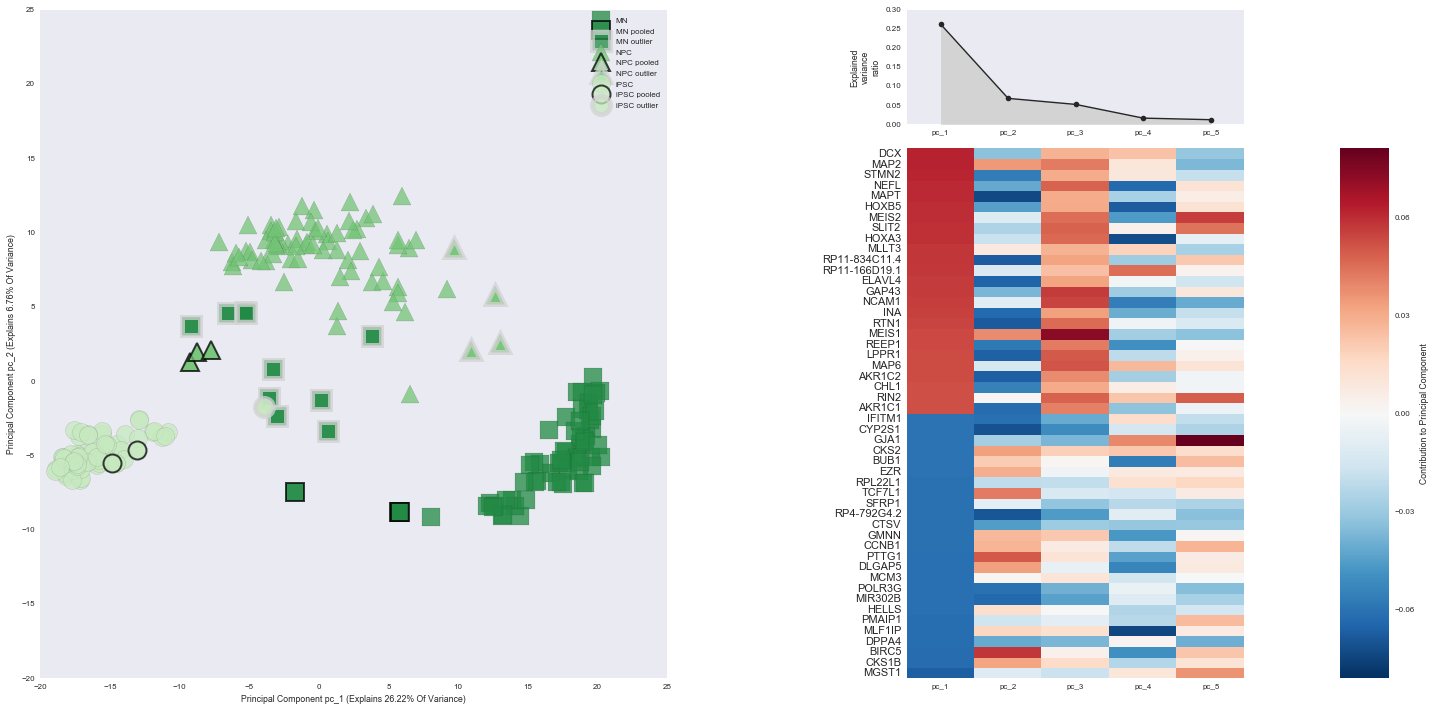

In [7]:
with sns.axes_style('dark'):
    viz = study.plot_pca(show_vectors=False, scale_by_variance=False, markersize=18)
    xmin, xmax, ymin, ymax = viz.ax_components.axis()
    vmin = min(xmin, ymin)
    vmax = max(xmax, ymax)
    viz.ax_components.set(xlim=(vmin, vmax), ylim=(vmin, vmax))
    viz.fig_reduced.savefig('{}/expression_pca.pdf'.format(folder))